## ACTIVSg grid buildout: Part 1
## TESTING HSDS

* works on Kestrel
* conda: buildouts (with pysam=4.1.0 and reV=0.8.2)
* reading in ACTIVSg grid files
* setting up SAM & reV
* running reV
* applying exclusion map
* producing and saving all_cf_df.csv for Part 2

In [1]:
## to see current python kernel in use:
## (too find your kernel in the dropdow do:
## 
import sys
sys.executable

'/projects/hpcapps/isatkaus/conda-envs/buildouts/bin/python'

In [2]:
import os
from reV import TESTDATADIR
from reV.config.project_points import ProjectPoints
from reV.generation.generation import Gen

import numpy as np
import matplotlib.pyplot as plt
import json


import rex
from rex import Resource

import h5py
import glob


In [3]:
import pandas as pd
import numpy as np
import time
import os

#### not using pywwtk anymore, using eaw wtk data instead
# # set PYWTK_CACHE_DIR to locate WIND Toolkit data
# # will download from AWS as needed
# os.environ["PYWTK_CACHE_DIR"] = os.path.join(os.environ["HOME"], "pywtk-data")

from powerscenarios.parser import Parser
from powerscenarios.grid import Grid

# show multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 30)

# plotting (optional)
import cufflinks as cl

cl.go_offline()

In [4]:
# voronoi
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

In [5]:

import geopandas as gpd
import contextily as ctx
import shapely
# same as above but using shapely.Point
from shapely.geometry import Point, LineString, Polygon

from pyproj import Proj, transform
import rasterio
from rasterio.plot import show
import pyproj

import h5pyd

In [6]:
import PySAM
import reV
print(f"nrel-pysam version {PySAM.__version__}")
print(f"nrel-reV verion: {reV.__version__}")
print(f"python version: {sys.version}")

nrel-pysam version 4.1.0
nrel-reV verion: 0.8.2
python version: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]


* select grid
<a id='select_grid'></a>

[SAM parameters](#sam_parameters)

# load TAMU grid data
* choose TAMU grid - uncomment appropriate line
* grid files can be downloaded from:
* https://electricgrids.engr.tamu.edu/electric-grid-test-cases/

In [7]:

grid_name = "ACTIVSg200"  # TAMU 200 bus case
# grid_name = "ACTIVSg2000"  # TAMU 2000 bus case
# grid_name = 'ACTIVSg10k' # TAMU 10000 bus case
# grid_name = 'ACTIVSg70k' # TAMU 70000 bus case


# path to .aux file (TAMU grids) obtained from e.g.
# https://electricgrids.engr.tamu.edu/electric-grid-test-cases/activsg200/
data_dir = "/projects/hpcapps/isatkaus/grid-buildouts-data/grid-data/"
# aux_file_name = data_dir + grid_name + "/" + grid_name + ".aux"
aux_file_name = os.path.join(data_dir, grid_name, grid_name + ".aux")

# parse original .aux file and return dataframes for buses, generators, and wind generators
# here, we need .aux files because those are the only ones with Latitute/Longitude information
parser = Parser()
bus_df, gen_df, wind_gen_df = parser.parse_tamu_aux(aux_file_name)

# see what you got
print("bus_df:")
bus_df
print("gen_df:")
gen_df
print("wind_gen_df:")
wind_gen_df

grid = Grid(grid_name, bus_df, gen_df, wind_gen_df)
grid
print(grid.info())


# branches
# m_filename = data_dir + "/grid-data/" + grid_name + "/case_" + grid_name + ".m"
m_filename = os.path.join(data_dir + grid_name + "/case_" + grid_name + ".m")

# read branch table from scenarios_m_file
table_name = "mpc.branch"
column_names = [
    "fbus",
    "tbus",
    "r",
    "x",
    "b",
    "rateA",
    "rateB",
    "rateC",
    "ratio",
    "angle",
    "status",
    "angmin",
    "angmax",
    "Pf",
    "Qf",
    "Pt",
    "Qt",
    "mu_Sf",
    "mu_St",
    "mu_angmin",
    "mu_angmax",
]

# this table is entirely numeric
numeric_columns = column_names

branch_df = parser.read_m_table(
    m_filename,
    table_name=table_name,
    column_names=column_names,
    numeric_columns=numeric_columns,
)


# rename a few columns to match branch drawing script
branch_df.index.rename("UID", inplace=True)
branch_df.rename(columns={"fbus": "FromBus", "tbus": "ToBus"}, inplace=True)
print("\nbranch_df")
branch_df

# ############usts data
# usts_data_dir = "/Users/isatkaus/projects/ecp/powerscenarios/data/grid-data/USATestSystem/formatted/"

# filename = os.path.join(usts_data_dir, "branch.csv")
# branch_df = pd.read_csv(filename, index_col=0)
# print("\nbranch_df")
# branch_df


bus_df:


BusNum       BusName   Latitude  Longitude  Zone
0         1   CREVECOEUR0  40.642116 -89.599560     2
1         2   CREVECOEUR1  40.642116 -89.599560     2
2         3   ILLIOPOLIS0  39.866030 -89.251291     4
3         4   ILLIOPOLIS1  39.866030 -89.251291     4
..      ...           ...        ...        ...   ...
196     197  GIBSONCITY12  40.470500 -88.398700     6
197     198     MAPLETON0  40.556403 -89.762073     2
198     199      GIFFORD0  40.306027 -87.958606     6
199     200   PETERSBURG0  40.169931 -89.986537     4

[200 rows x 5 columns]

gen_df:


BusNum  GenID    GenMWMax    GenMWMin  GenWindPowerFactor GenFuelType  \
0       49      1    4.530000    1.360000                 1.0        Coal   
1       50      1    4.530000    1.360000                 1.0        Coal   
2       51      1    4.530000    1.360000                 1.0        Coal   
3       52      1    4.530000    1.360000                 1.0        Coal   
..     ...    ...         ...         ...                 ...         ...   
45     183      1   26.600000    7.980000                 1.0        Coal   
46     189      1  569.150019  170.749998                 1.0     Nuclear   
47     196      1   67.500001   20.250000                 1.0  NaturalGas   
48     197      1   67.500001   20.250000                 1.0  NaturalGas   

              GenUID        BusName   Latitude  Longitude  Zone  
0          49_Coal_1      RANTOUL21  40.312222 -88.159444     6  
1          50_Coal_1      RANTOUL22  40.312222 -88.159444     6  
2          51_Coal_1      RANTOUL23  40.312222 -88.159444     6  
3          52_Coal_1      RANTOUL24  40.312222 -88.159444     6  
..               ...            ...        ...        ...   ...  
45        183_Coal_1  SPRINGFIELD22  39.806868 -89.641653     4  
46     189_Nuclear_1      CLINTON12  40.171900 -88.833900     7  
47  196_NaturalGas_1   GIBSONCITY11  40.470500 -88.398700     6  
48  197_NaturalGas_1   GIBSONCITY12  40.470500 -88.398700     6  

[49 rows x 11 columns]

wind_gen_df:


BusNum  GenID    GenMWMax   GenMWMin  GenWindPowerFactor GenFuelType  \
0      65      1  150.399995  45.120001                 1.0        Wind   
1     104      1   99.000001  29.699999                 1.0        Wind   
2     105      1  198.000002  59.400004                 1.0        Wind   
3     114      1    1.700000   0.510000                 1.0        Wind   
4     115      1  150.000000  44.999999                 1.0        Wind   
5     147      1  100.500000  30.149999                 1.0        Wind   

       GenUID      BusName  Latitude  Longitude  Zone  
0   65_Wind_1     PAXTON11  40.46405 -88.021517     6  
1  104_Wind_1  ELLSWORTH12  40.47920 -88.798900     7  
2  105_Wind_1  ELLSWORTH13  40.47920 -88.798900     7  
3  114_Wind_1     NORMAL22  40.53700 -89.019000     7  
4  115_Wind_1     NORMAL23  40.53700 -89.019000     7  
5  147_Wind_1   HOPEDALE21  40.36920 -89.402200     7

Grid(name=ACTIVSg200, buses=200, generators=49, wind_generators=6, wind_sites=0)


ACTIVSg200 grid info: 

 number of buses: 200
 number of generators: 49
 number of wind generators: 6
 number of solar generators: 0
 total generator capacity: 3602.84 MW
 wind capacity/penetration: 699.60 MW / 19.42%
 solar capacity/penetration: 0.00 MW / 0.00%

branch_df


FromBus  ToBus         r         x        b  rateA  rateB  rateC  ratio  \
UID                                                                            
0          2      1  0.000673  0.003339  0.00000  100.0      0      0      0   
1          1    119  0.018542  0.119758  0.02285  221.1      0      0      0   
2        124      1  0.005615  0.036268  0.00692  221.1      0      0      0   
3        193      1  0.004258  0.027501  0.00525  221.1      0      0      0   
..       ...    ...       ...       ...      ...    ...    ...    ...    ...   
241      188    187  0.001394  0.044762  0.00000  400.0      0      0      1   
242      189    187  0.000300  0.007815  0.00000  740.0      0      0      1   
243      196    195  0.002850  0.060038  0.00000   87.7      0      0      1   
244      197    195  0.002850  0.191484  0.00000   87.7      0      0      1   

     angle  status  angmin  angmax      Pf     Qf      Pt     Qt  mu_Sf  \
UID                                                                       
0        0       1       0       0   -7.39  -2.10    7.39   2.11    0.0   
1        0       1       0       0   12.25  -0.57  -12.22  -1.63    0.0   
2        0       1       0       0   40.13   7.94  -40.04  -8.08    0.0   
3        0       1       0       0  -20.39  -6.96   20.41   6.54    0.0   
..     ...     ...     ...     ...     ...    ...     ...    ...    ...   
241      0       1       0       0 -113.10   8.78  113.27  -3.48    0.0   
242      0       1       0       0  384.37 -24.15 -383.96  34.87    0.0   
243      0       1       0       0    0.00   0.00    0.00   0.00    0.0   
244      0       1       0       0    0.00   0.00    0.00   0.00    0.0   

     mu_St  mu_angmin  mu_angmax  
UID                               
0      0.0        0.0        0.0  
1      0.0        0.0        0.0  
2      0.0        0.0        0.0  
3      0.0        0.0        0.0  
..     ...        ...        ...  
241    0.0        0.0        0.0  
242    0.0        0.0        0.0  
243    0.0        0.0        0.0  
244    0.0        0.0        0.0  

[245 rows x 21 columns]

In [8]:
# distance between lat,lon points
import math


def distance(lat1, lon1, lat2, lon2):

    lat1 = math.radians(abs(lat1))
    lon1 = math.radians(abs(lon1))
    lat2 = math.radians(abs(lat2))
    lon2 = math.radians(abs(lon2))

    R = 6373.0
    # radius of the Earth
    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

# calculate line distances
# add to/from lat/lon to the branch df
# def distance(lat1, lon1, lat2, lon2):

for line_uid in branch_df.index:
    from_latitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "FromBus"], "Latitude"
    ]
    from_longitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "FromBus"], "Longitude"
    ]
    to_latitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "ToBus"], "Latitude"
    ]
    to_longitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "ToBus"], "Longitude"
    ]

    branch_df.loc[line_uid, "distance"] = distance(
        from_latitude, from_longitude, to_latitude, to_longitude
    )

    branch_df.loc[line_uid, "from_latitude"] = from_latitude
    branch_df.loc[line_uid, "from_longitude"] = from_longitude
    branch_df.loc[line_uid, "to_latitude"] = to_latitude
    branch_df.loc[line_uid, "to_longitude"] = to_longitude


##  gdfs for plotting

Latitude  Longitude                    geometry
BusNum                                                  
1       40.642116 -89.599560  POINT (-89.59956 40.64212)
2       40.642116 -89.599560  POINT (-89.59956 40.64212)
3       39.866030 -89.251291  POINT (-89.25129 39.86603)
4       39.866030 -89.251291  POINT (-89.25129 39.86603)
...           ...        ...                         ...
197     40.470500 -88.398700  POINT (-88.39870 40.47050)
198     40.556403 -89.762073  POINT (-89.76207 40.55640)
199     40.306027 -87.958606  POINT (-87.95861 40.30603)
200     40.169931 -89.986537  POINT (-89.98654 40.16993)

[200 rows x 3 columns]

subgraph
BusNum          
1              2
2              2
3              2
4              2
...          ...
197            3
198            1
199            1
200            1

[200 rows x 1 columns]

Latitude  Longitude                    geometry  size
BusNum                                                        
1       40.642116 -89.599560  POINT (-89.59956 40.64212)    20
2       40.642116 -89.599560  POINT (-89.59956 40.64212)    20
3       39.866030 -89.251291  POINT (-89.25129 39.86603)    20
4       39.866030 -89.251291  POINT (-89.25129 39.86603)    20
...           ...        ...                         ...   ...
197     40.470500 -88.398700  POINT (-88.39870 40.47050)    30
198     40.556403 -89.762073  POINT (-89.76207 40.55640)    10
199     40.306027 -87.958606  POINT (-87.95861 40.30603)    10
200     40.169931 -89.986537  POINT (-89.98654 40.16993)    10

[200 rows x 4 columns]


number of unique latlons: 111 out of 2000


Latitude  Longitude                    geometry  size
BusNum                                                        
1       40.642116 -89.599560  POINT (-89.59956 40.64212)    20
3       39.866030 -89.251291  POINT (-89.25129 39.86603)    20
5       40.378337 -88.105151  POINT (-88.10515 40.37834)    20
7       40.712882 -89.576722  POINT (-89.57672 40.71288)    20
...           ...        ...                         ...   ...
195     40.470500 -88.398700  POINT (-88.39870 40.47050)    30
198     40.556403 -89.762073  POINT (-89.76207 40.55640)    10
199     40.306027 -87.958606  POINT (-87.95861 40.30603)    10
200     40.169931 -89.986537  POINT (-89.98654 40.16993)    10

[111 rows x 4 columns]

<AxesSubplot: >

FromBus  ToBus  from_latitude  from_longitude  to_latitude  to_longitude  \
UID                                                                             
0          2      1      40.642116      -89.599560    40.642116    -89.599560   
1          1    119      40.642116      -89.599560    40.870710    -89.353494   
2        124      1      40.595800      -89.663100    40.642116    -89.599560   
3        193      1      40.676541      -89.633346    40.642116    -89.599560   
..       ...    ...            ...             ...          ...           ...   
241      188    187      40.171900      -88.833900    40.171900    -88.833900   
242      189    187      40.171900      -88.833900    40.171900    -88.833900   
243      196    195      40.470500      -88.398700    40.470500    -88.398700   
244      197    195      40.470500      -88.398700    40.470500    -88.398700   

                        FromPoint                      ToPoint  \
UID                                                              
0     POINT (-89.59956 40.642116)  POINT (-89.59956 40.642116)   
1     POINT (-89.59956 40.642116)  POINT (-89.353494 40.87071)   
2        POINT (-89.6631 40.5958)  POINT (-89.59956 40.642116)   
3    POINT (-89.633346 40.676541)  POINT (-89.59956 40.642116)   
..                            ...                          ...   
241      POINT (-88.8339 40.1719)     POINT (-88.8339 40.1719)   
242      POINT (-88.8339 40.1719)     POINT (-88.8339 40.1719)   
243      POINT (-88.3987 40.4705)     POINT (-88.3987 40.4705)   
244      POINT (-88.3987 40.4705)     POINT (-88.3987 40.4705)   

                                              geometry  
UID                                                     
0    LINESTRING (-89.59956 40.642116, -89.59956 40....  
1    LINESTRING (-89.59956 40.642116, -89.353494 40...  
2    LINESTRING (-89.6631 40.5958, -89.59956 40.642...  
3    LINESTRING (-89.633346 40.676541, -89.59956 40...  
..                                                 ...  
241    LINESTRING (-88.8339 40.1719, -88.8339 40.1719)  
242    LINESTRING (-88.8339 40.1719, -88.8339 40.1719)  
243    LINESTRING (-88.3987 40.4705, -88.3987 40.4705)  
244    LINESTRING (-88.3987 40.4705, -88.3987 40.4705)  

[245 rows x 9 columns]

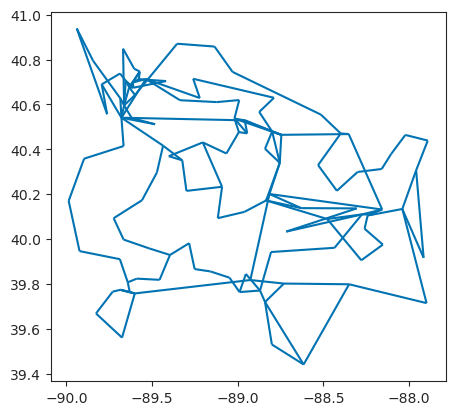

In [9]:
#####################################
##########bus_df
####################################

b_df = bus_df[["BusNum", "Latitude", "Longitude"]].set_index("BusNum").copy()
# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
bus_gdf = gpd.GeoDataFrame(
    b_df,
    geometry=gpd.points_from_xy(b_df["Longitude"], b_df["Latitude"]),
    crs="epsg:4326",
)
bus_gdf


###### OPTIONAL: make bus "sizes" reflect the number of buses at the same latlon
df = bus_gdf.copy()
df["subgraph"] = 1


df = (
    df[["Latitude", "Longitude", "subgraph"]]
    .groupby(["Latitude", "Longitude"])
    .transform("count")
)
df

bus_gdf["size"] = df["subgraph"] * 10
bus_gdf

####  unique latlons
bus_unique_gdf = bus_gdf.drop_duplicates(["Latitude", "Longitude"])
print("\nnumber of unique latlons: {} out of 2000".format(len(bus_unique_gdf)))
bus_unique_gdf


####

###########################################
############ branch_df
##############################################

br_df = branch_df[
    [
        "FromBus",
        "ToBus",
        "from_latitude",
        "from_longitude",
        "to_latitude",
        "to_longitude",
    ]
].copy()

############## make from/to Points

br_df["FromPoint"] = [
    Point(x, y) for x, y in zip(br_df["from_longitude"], br_df["from_latitude"])
]
br_df["ToPoint"] = [
    Point(x, y) for x, y in zip(br_df["to_longitude"], br_df["to_latitude"])
]


############ lines
br_df["geometry"] = [
    LineString([x1, x2]) for x1, x2 in zip(br_df["FromPoint"], br_df["ToPoint"])
]


# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
br_gdf = gpd.GeoDataFrame(br_df, geometry="geometry", crs="epsg:4326")

br_gdf.plot()

br_df


bus_gdf = bus_gdf.to_crs(epsg=3857)
br_gdf = br_gdf.to_crs(epsg=3857)



# experiment dir
* select run_dir for reV runs: input and output
* change msg describing experiment for logging purposes


In [10]:
#run_dir = "/projects/exasgd/isatkaus/buildout/wind/wind_gen_tamu5"
#run_dir = "/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v5"
#run_dir = "/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v6"
#run_dir = "/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v7"
run_dir = "/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v9"

if not os.path.exists(run_dir):
    os.makedirs(run_dir)


import PySAM
import reV
import datetime

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

msg = f"""
TESTING HSDS
experiment date: {now}
tamu200 grid, all years 
two ATB-mid30 turbines per WTK cell 
nrel-pysam version {PySAM.__version__}
nrel-reV verion: {reV.__version__}
python version: {sys.version}
using 5-min resource files (all files with * for the height)
"""

# quick readme to know what experiment we're running
filename = os.path.join(run_dir, "readme.txt")
with open(filename, "w") as f:
    f.write(msg)

print(f"\n writting msg, to {filename}: \n")
print(msg)

316


 writting msg, to /home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v9/readme.txt: 


TESTING HSDS
experiment date: 2023-12-08 15:55:31
tamu200 grid, all years 
two ATB-mid30 turbines per WTK cell 
nrel-pysam version 4.1.0
nrel-reV verion: 0.8.2
python version: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
using 5-min resource files (all files with * for the height)



# project points
* select years of data that will be used in the reV run below. 
* it is recommended to use all available, e.g., WTK has 7 years 2007-2013
* also select resourse file res_file:
* here we just need one file (one year, one hh) to extract gid's of sites
* that we will use to run reV on (project points)



In [11]:
# # on HSDS
# res_file = "/nrel/wtk/conus-5min/wtk_conus_2007.h5"
# res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

# wind resource file on Eagle
#res_file = "/lustre/eaglefs/OLD-datasets/WIND/conus/v1.0.0/wtk_conus_2007.h5"
year = 2007
years = [2007,2008,2009,2010,2011,2012,2013]
#years = [2007,2008]

### this is on lustre file sytem (works)
#res_file = f"/lustre/eaglefs/OLD-datasets/WIND/conus/v1.0.0/wtk_conus_{year}.h5"


# ### vast flash-based system (works) HOURLY
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/wtk_conus_{years[0]}.h5"

# ### vast flash-based system (works) 5-MIN
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_120m.h5"

### Kestrel 5-min, lustre (there is no vast flash-based on Kestrel)
res_file = f"/kfs2/pdatasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_120m.h5"
res = rex.resource_extraction.resource_extraction.ResourceX(res_file,)


# # small box
# #gids = res.box_gids((37, -120), (36.7, -119.7))
# gids = res.box_gids((34.55, -117.2), (34.24, -116.86)) # 259 points 

# # RTS bounding box
# gids = res.box_gids((37, -120), (32.5, -112))


###### create TAMU box, rectangle that includes entire grid selected above
extra_lat = 0.3
extra_lon = 0.3
top = bus_df["Latitude"].max() + extra_lat
bottom = bus_df["Latitude"].min() - extra_lat
right = bus_df["Longitude"].max() + extra_lon
left = bus_df["Longitude"].min() - extra_lon

gids = res.box_gids((top, left), (bottom, right))


pp_df = pd.DataFrame(index=gids)
pp_df.index.name = 'gid'
# 'default' will be defined in config_gen.json
pp_df['config']='default'
pp_df



# #scratch dir
# df.to_csv('/scratch/isatkaus/projects/dispatches/experiments/full_pipeline_execution/pp.csv')
#df.to_csv('/scratch/isatkaus/projects/dispatches/experiments/wind_gen/pp.csv')
pp_df.to_csv(os.path.join(run_dir,'pp.csv'))




config
gid             
1578401  default
1578402  default
1578403  default
1578404  default
...          ...
1723329  default
1723330  default
1723331  default
1724517  default

[12563 rows x 1 columns]

## HSDS
* is there 5-min wind data via HSDS?

In [16]:
### test hsds connection
with h5pyd.Folder('/nrel/') as f:
    print(list(f))

with h5pyd.Folder('/nrel/wtk/conus-5min/') as f:
    print(list(f))

['US_wave', 'building_synthetic_dataset', 'dsgrid-2018-efs', 'nsrdb', 'porotomo', 'sup3rcc', 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_pressure_2015.h5', 'umcm', 'wtk-us.h5', 'wtk']
['wtk_conus_2007.h5', 'wtk_conus_2008.h5', 'wtk_conus_2009.h5', 'wtk_conus_2010.h5', 'wtk_conus_2011.h5', 'wtk_conus_2012.h5', 'wtk_conus_2013.h5', 'wtk_conus_2014.h5']


In [13]:
# on HSDS
res_file = "/nrel/wtk/conus-5min/wtk_conus_2007.h5"
res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

###### create TAMU box, rectangle that includes entire grid selected above
extra_lat = 0.3
extra_lon = 0.3
top = bus_df["Latitude"].max() + extra_lat
bottom = bus_df["Latitude"].min() - extra_lat
right = bus_df["Longitude"].max() + extra_lon
left = bus_df["Longitude"].min() - extra_lon

gids = res.box_gids((top, left), (bottom, right))


pp_df = pd.DataFrame(index=gids)
pp_df.index.name = 'gid'
# 'default' will be defined in config_gen.json
pp_df['config']='default'
pp_df



config
gid             
1578401  default
1578402  default
1578403  default
1578404  default
...          ...
1723329  default
1723330  default
1723331  default
1724517  default

[12563 rows x 1 columns]

In [ ]:
# # on HSDS
# res_file = "/nrel/wtk/conus-5min/wtk_conus_2007.h5"
# res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

# wind resource file on Eagle
#res_file = "/lustre/eaglefs/OLD-datasets/WIND/conus/v1.0.0/wtk_conus_2007.h5"
year = 2007
years = [2007,2008,2009,2010,2011,2012,2013]
#years = [2007,2008]

### this is on lustre file sytem (works)
#res_file = f"/lustre/eaglefs/OLD-datasets/WIND/conus/v1.0.0/wtk_conus_{year}.h5"


# ### vast flash-based system (works) HOURLY
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/wtk_conus_{years[0]}.h5"

# ### vast flash-based system (works) 5-MIN
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_120m.h5"

# ### Kestrel 5-min, lustre (there is no vast flash-based on Kestrel)
# res_file = f"/kfs2/pdatasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_120m.h5"
# res = rex.resource_extraction.resource_extraction.ResourceX(res_file,)


###### create TAMU box, rectangle that includes entire grid selected above
extra_lat = 0.3
extra_lon = 0.3
top = bus_df["Latitude"].max() + extra_lat
bottom = bus_df["Latitude"].min() - extra_lat
right = bus_df["Longitude"].max() + extra_lon
left = bus_df["Longitude"].min() - extra_lon

gids = res.box_gids((top, left), (bottom, right))


pp_df = pd.DataFrame(index=gids)
pp_df.index.name = 'gid'
# 'default' will be defined in config_gen.json
pp_df['config']='default'
pp_df



# #scratch dir
# df.to_csv('/scratch/isatkaus/projects/dispatches/experiments/full_pipeline_execution/pp.csv')
#df.to_csv('/scratch/isatkaus/projects/dispatches/experiments/wind_gen/pp.csv')
pp_df.to_csv(os.path.join(run_dir,'pp.csv'))




In [12]:

run_dir

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

In [13]:
### save project points with lat/lons for possible plotting
## get mata data of the resource (we need latlons)
meta_df = res.meta
meta_df
filename = "meta_df.csv"
meta_df.to_csv(os.path.join(run_dir, filename))
### get latlons of pp points only for visualization
pps_df = meta_df.loc[pp_df.index, ["latitude", "longitude"]]
pps_df

### save pps_df
run_dir
filename = "pps_df.csv"
pps_df.to_csv(os.path.join(run_dir, filename))

latitude   longitude country state county  timezone  elevation  \
gid                                                                        
0        37.603382 -127.617050    None  None   None        -9          0   
1        37.620419 -127.626007    None  None   None        -9          0   
2        37.637451 -127.634979    None  None   None        -9          0   
3        37.654484 -127.643951    None  None   None        -9          0   
...            ...         ...     ...   ...    ...       ...        ...   
2488132  40.351830  -65.745911    None  None   None        -4          0   
2488133  40.369072  -65.736938    None  None   None        -4          0   
2488134  40.386314  -65.727936    None  None   None        -4          0   
2488135  40.403545  -65.718933    None  None   None        -4          0   

         offshore  
gid                
0               1  
1               1  
2               1  
3               1  
...           ...  
2488132         1  
2488133         1  
2488134         1  
2488135         1  

[2488136 rows x 8 columns]

latitude  longitude
gid                          
1578401  41.145519 -90.285706
1578402  41.164040 -90.283936
1578403  41.182556 -90.282166
1578404  41.201092 -90.280426
...            ...        ...
1723329  39.306717 -87.596405
1723330  39.325130 -87.593903
1723331  39.343555 -87.591400
1724517  39.157475 -87.592682

[12563 rows x 2 columns]

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

[Select grid](#select_grid)

* sam parameters
<a id='sam_parameters'></a>

[Run ReV](#run_rev)

# SAM file: select tecnology
* create SAM json describing technology inside WTK grid cell
* can use SAM GUI to create .json file 
* or write/modify manually (e.g. ATB turbines are not in SAM library) 
* we'll use ATB 2030 land based 5.5 MW wind example input just add second turbine
* technically, adding a scond turbine is not necessary, can use one, but then multiply the output by capacity density (as we do with solar)
* ATB (Annual Technology Baseline)


In [14]:
# # standard SAM input used by reV
# sam_filename_in = "/home/isatkaus/projects/dispatches/reV/tests/data/SAM/wind_gen_standard_losses_0.json"
# sam_filename_out = os.path.join(run_dir,"wind_gen1.json")

# SAM file (ATB-mid turbine)
sam_filename_in = "/projects/hpcapps/isatkaus/grid-buildouts-data/sam-templates/land_3_2030_midcost_medinnov.json"
sam_filename_out = os.path.join(run_dir, "wind_gen_2atb_turbine.json")

with open(sam_filename_in) as f:
    data = json.load(f)

data

# add second turbine
data["wind_farm_xCoordinates"].append(1000)
data["wind_farm_yCoordinates"].append(1000)
data["system_capacity"] = data["system_capacity"] * 2
data
with open(sam_filename_out, "w") as f:
    json.dump(data, f, indent=2, sort_keys=True)

{'adjust:constant': 0.0,
 'capital_cost': 6022005,
 'fixed_operating_cost': 202455,
 'fixed_charge_rate': 0.063,
 'system_capacity': 5500.0,
 'wind_farm_xCoordinates': [0],
 'wind_farm_yCoordinates': [0],
 'wind_farm_losses_percent': 11.799999999999999,
 'wind_farm_wake_model': 0,
 'wind_resource_model_choice': 0,
 'wind_resource_shear': 0.14,
 'wind_resource_turbulence_coeff': 0.1,
 'wind_turbine_cutin': 0.0,
 'wind_turbine_hub_ht': 120,
 'wind_turbine_rotor_diameter': 175,
 'variable_operating_cost': 0,
 'wind_turbine_powercurve_powerout': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  127,
  178,
  237,
  305,
  381,
  468,
  564,
  671,
  789,
  919,
  1061,
  1216,
  1385,
  1567,
  1765,
  1977,
  2205,
  2450,
  2711,
  2990,
  3287,
  3602,
  3937,
  4291,
  4665,
  5060,
  5477,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500

{'adjust:constant': 0.0,
 'capital_cost': 6022005,
 'fixed_operating_cost': 202455,
 'fixed_charge_rate': 0.063,
 'system_capacity': 11000.0,
 'wind_farm_xCoordinates': [0, 1000],
 'wind_farm_yCoordinates': [0, 1000],
 'wind_farm_losses_percent': 11.799999999999999,
 'wind_farm_wake_model': 0,
 'wind_resource_model_choice': 0,
 'wind_resource_shear': 0.14,
 'wind_resource_turbulence_coeff': 0.1,
 'wind_turbine_cutin': 0.0,
 'wind_turbine_hub_ht': 120,
 'wind_turbine_rotor_diameter': 175,
 'variable_operating_cost': 0,
 'wind_turbine_powercurve_powerout': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  127,
  178,
  237,
  305,
  381,
  468,
  564,
  671,
  789,
  919,
  1061,
  1216,
  1385,
  1567,
  1765,
  1977,
  2205,
  2450,
  2711,
  2990,
  3287,
  3602,
  3937,
  4291,
  4665,
  5060,
  5477,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
  5500,
 

# reV generation config
* setup reV generation module run: number of nodes, allocation, resourse files (5-min, 1-hr, hub_height, etc), output data request..
* use lustre file system for large runs, else vast is fine
* make sure to change to your HPC allocation (execution_control)
* see docs at:
* https://nrel.github.io/reV/_cli/reV%20generation.html

In [15]:
import reV
reV.__version__
run_dir

'0.8.2'

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

In [16]:
#################################
#### these are for nrel-rev=0.8.2
#################################

config_filename_in = "/projects/hpcapps/isatkaus/grid-buildouts-data/rev-configs/config_gen.json"
config_filename_out = os.path.join(run_dir, "config_gen.json")

with open(config_filename_in) as f:
    data = json.load(f)

data

### "directories" keyword arg is depreciated (works in older reV, only)
data.pop("directories", None)
data["log_directory"] = "./logs/"

#data["analysis_years"] = [years[0]]
data["analysis_years"] = years

# execution: pick YOUR allocation
#data["execution_control"]["allocation"] = "hpcapps"
data["execution_control"]["allocation"] = "exasgd"
#data["execution_control"]["allocation"] = "aiuserapps"
#
# data['execution_control']['feature']='--qos=high' # this key is in the default
#data['execution_control']['feature']='--qos=normal'
data["execution_control"].pop("feature", None)

data["execution_control"]["qos"] = "normal"
#data["execution_control"]["qos"] = "standby"
data["execution_control"]["walltime"] = 4.0
data["execution_control"]["nodes"] = 20

### pick compute sytem 
data["execution_control"]["option"] = "kestrel"
#data["execution_control"]["option"] = "eagle"
#data["execution_control"]["option"] = "slurm"
#data["execution_control"]["option"] = "local"

# SAM input
data["sam_files"]["default"] = sam_filename_out

# SAM output
data["output_request"] = [
    "cf_mean",
    "cf_profile",
    "gen_profile",
    "lcoe_fcr",
    "ws_mean",
    "annual_energy",
]


# project points
data["project_points"] = "pp.csv"

# resource
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/wtk_conus_{years[0]}.h5"
# res_file1 = f"/vast/datasets/WIND/conus/v1.0.0/wtk_conus_{years[1]}.h5"

############################# lustre datasets are now in OLD-datasets:
#### /lustre/eaglefs/OLD-datasets/
# data["resource_file"] = (
#     "/lustre/eaglefs/datasets/WIND/conus/v1.0.0/"
#     + str(year)
#     + "/wtk_conus_"
#     + str(year)
#     + "_*.h5"
# )

############################# vast
# #### these are HOURLY
# data["resource_file"]=[f"/vast/datasets/WIND/conus/v1.0.0/wtk_conus_{year}.h5" for year in years]

# #### these are 5-MIN
# data["resource_file"]=[f"/vast/datasets/WIND/conus/v1.0.0/{year}/wtk_conus_{year}_120m.h5" for year in years]

# #### these are 5-MIN (all heights)
# data["resource_file"] = [
#     f"/vast/datasets/WIND/conus/v1.0.0/{year}/wtk_conus_{year}_*.h5" for year in years
# ]

############################# on Kestrel (all lustre)
####  these are 5-MIN (all heights, all years)
data["resource_file"] = [
    f"/kfs2/pdatasets/WIND/conus/v1.0.0/{year}/wtk_conus_{year}_*.h5" for year in years
]

# ############################# on Kestrel one year (all lustre)
# ####  these are 5-MIN (all heights, one year)
# data["resource_file"] = [
#     f"/kfs2/pdatasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_*.h5"]


data["technology"] = "windpower"

data


with open(config_filename_out, "w") as f:
    json.dump(data, f, indent=2, sort_keys=True)

{'analysis_years': [2011, 2012, 2013],
 'directories': {'log_directory': './logs/', 'output_directory': './'},
 'execution_control': {'allocation': 'gmihybridsys',
  'feature': '--qos=high',
  'memory': 90,
  'nodes': 20,
  'option': 'eagle',
  'sites_per_worker': 100,
  'walltime': 4.0},
 'log_level': 'INFO',
 'output_request': ['cf_mean', 'cf_profile', 'lcoe_fcr', 'ghi_mean'],
 'project_points': './pp.csv',
 'resource_file': '/lustre/eaglefs/datasets/NSRDB/v3/nsrdb_{}.h5',
 'sam_files': {'default': './pv.json'},
 'technology': 'pvwattsv7'}

{'log_directory': './logs/', 'output_directory': './'}

'--qos=high'

{'analysis_years': [2007, 2008, 2009, 2010, 2011, 2012, 2013],
 'execution_control': {'allocation': 'exasgd',
  'memory': 90,
  'nodes': 20,
  'option': 'kestrel',
  'sites_per_worker': 100,
  'walltime': 4.0,
  'qos': 'normal'},
 'log_level': 'INFO',
 'output_request': ['cf_mean',
  'cf_profile',
  'gen_profile',
  'lcoe_fcr',
  'ws_mean',
  'annual_energy'],
 'project_points': 'pp.csv',
 'resource_file': ['/kfs2/pdatasets/WIND/conus/v1.0.0/2007/wtk_conus_2007_*.h5',
  '/kfs2/pdatasets/WIND/conus/v1.0.0/2008/wtk_conus_2008_*.h5',
  '/kfs2/pdatasets/WIND/conus/v1.0.0/2009/wtk_conus_2009_*.h5',
  '/kfs2/pdatasets/WIND/conus/v1.0.0/2010/wtk_conus_2010_*.h5',
  '/kfs2/pdatasets/WIND/conus/v1.0.0/2011/wtk_conus_2011_*.h5',
  '/kfs2/pdatasets/WIND/conus/v1.0.0/2012/wtk_conus_2012_*.h5',
  '/kfs2/pdatasets/WIND/conus/v1.0.0/2013/wtk_conus_2013_*.h5'],
 'sam_files': {'default': '/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8/wind_gen_2atb_turbine.json'},
 'te

[SAM parameters](#sam_parameters)

* run reV commands
<a id='run_rev'></a>


[Apply exclusions](#apply_exclusions)

# on Kestrel's command line:
* will run all "years"

ssh to kestrel via terminal

cd to experiment dir: run_dir

module load anaconda3 (default 2022)
* or

module load anaconda3/2023.07-2

conda activate buildouts

reV generation -c config_gen.json (nrel-rev=0.8.2) 

* monitor your batch jobs, proceed only after they finished:

squeue -u $USER

In [17]:
run_dir

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

# processing .h5
* after batch jobs complete, run_dir will contain .h5 files with data
* based on config_gen.json the output will have N (e.g. N=20 nodes) .h5 files, each containing ~equal number of gid's

In [18]:
run_dir

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

In [19]:
!cat {run_dir}/readme.txt


experiment date: 2023-11-03 12:26:55
tamu200 grid, all years 
two ATB-mid30 turbines per WTK cell 
nrel-pysam version 4.1.0
nrel-reV verion: 0.8.2
python version: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
using 5-min resource files (all files with * for the height)


In [20]:
!ls {run_dir}

config_gen.json
logs
meta_df.csv
pp.csv
pps_df.csv
readme.txt
wind_gen_2atb_turbine.json
wind-gen-tamu200-v8_generation_j000_2007.h5
wind-gen-tamu200-v8_generation_j001_2007.h5
wind-gen-tamu200-v8_generation_j002_2007.h5
wind-gen-tamu200-v8_generation_j003_2007.h5
wind-gen-tamu200-v8_generation_j004_2007.h5
wind-gen-tamu200-v8_generation_j005_2007.h5
wind-gen-tamu200-v8_generation_j006_2007.h5
wind-gen-tamu200-v8_generation_j007_2007.h5
wind-gen-tamu200-v8_generation_j008_2007.h5
wind-gen-tamu200-v8_generation_j009_2007.h5
wind-gen-tamu200-v8_generation_j010_2007.h5
wind-gen-tamu200-v8_generation_j011_2007.h5
wind-gen-tamu200-v8_generation_j012_2007.h5
wind-gen-tamu200-v8_generation_j013_2007.h5
wind-gen-tamu200-v8_generation_j014_2007.h5
wind-gen-tamu200-v8_generation_j015_2007.h5
wind-gen-tamu200-v8_generation_j016_2007.h5
wind-gen-tamu200-v8_generation_j017_2007.h5
wind-gen-tamu200-v8_generation_j018_2007.h5
wind-gen-tamu200-v8_generation_j019_2007.h5
wind-gen-tamu200-v8_generation_

### one file
* sanity check: take a look at one output file


In [22]:
## can base the buildout (cap factors) on whichever year (out of 2007-2013)
year = 2007

### for reV=0.8.2 naming convention 
filename = os.path.join(
    run_dir, run_dir.split("/")[-1] + "_generation_j000_" + str(year) + ".h5"
)

### display all available keys in the data
f = h5py.File(filename, "r")
print("\navailable data keys")
f.keys()

### display a few datasets by chosing a key
key = "meta"
print(f"\n {key}")
dataset = f.get(key)
df = pd.DataFrame(dataset[()])
df

key = "time_index"
print(f"\n {key}")
dataset = f.get(key)
df = pd.DataFrame(dataset[()])
df

key = "gen_profile"
print(f"\n {key}")
dataset = f.get(key)
df = pd.DataFrame(dataset[()])
df



available data keys


<KeysViewHDF5 ['annual_energy', 'cf_mean', 'cf_profile', 'gen_profile', 'lcoe_fcr', 'meta', 'time_index', 'ws_mean']>


 meta


latitude  longitude           country        state     county  timezone  \
0    41.145519 -90.285706  b'United States'  b'Illinois'    b'Knox'        -6   
1    41.164040 -90.283936  b'United States'  b'Illinois'   b'Henry'        -6   
2    41.182556 -90.282166  b'United States'  b'Illinois'   b'Henry'        -6   
3    41.201092 -90.280426  b'United States'  b'Illinois'   b'Henry'        -6   
..         ...        ...               ...          ...        ...       ...   
625  40.485409 -90.127563  b'United States'  b'Illinois'  b'Fulton'        -6   
626  40.503922 -90.125793  b'United States'  b'Illinois'  b'Fulton'        -6   
627  40.522415 -90.123993  b'United States'  b'Illinois'  b'Fulton'        -6   
628  40.540928 -90.122223  b'United States'  b'Illinois'  b'Fulton'        -6   

     elevation  offshore      gid      reV_tech  
0          231         0  1578401  b'windpower'  
1          229         0  1578402  b'windpower'  
2          240         0  1578403  b'windpower'  
3          242         0  1578404  b'windpower'  
..         ...       ...      ...           ...  
625        195         0  1589334  b'windpower'  
626        198         0  1589335  b'windpower'  
627        208         0  1589336  b'windpower'  
628        209         0  1589337  b'windpower'  

[629 rows x 10 columns]


 time_index


0
0       b'2007-01-01 00:00:00+00:00'
1       b'2007-01-01 00:05:00+00:00'
2       b'2007-01-01 00:10:00+00:00'
3       b'2007-01-01 00:15:00+00:00'
...                              ...
105116  b'2007-12-31 23:40:00+00:00'
105117  b'2007-12-31 23:45:00+00:00'
105118  b'2007-12-31 23:50:00+00:00'
105119  b'2007-12-31 23:55:00+00:00'

[105120 rows x 1 columns]


 gen_profile


0            1            2            3            4    \
0       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
1       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
2       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
3       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
...             ...          ...          ...          ...          ...   
105116  5762.623535  6268.617676  6762.202148  6762.075684  6333.137207   
105117  5917.824707  6454.371582  6881.667969  6857.646973  6427.387695   
105118  6165.107422  6717.232910  7054.819824  7004.189453  6594.638184   
105119  6440.009766  6982.089355  7307.302246  7256.667969  6809.672363   

                5            6            7            8            9    \
0       9702.000000  9702.000000  9669.571289  9702.000000  9702.000000   
1       9702.000000  9702.000000  9702.000000  9688.686523  9702.000000   
2       9702.000000  9702.000000  9702.000000  9702.000000  9696.787109   
3       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
...             ...          ...          ...          ...          ...   
105116  5696.123535  6309.036621  6690.816895  6644.760742  6524.187012   
105117  5802.315918  6449.699707  6906.109375  6836.148438  6739.488281   
105118  5937.175781  6760.648438  7257.805664  7082.783691  7031.188965   
105119  6094.510742  7129.337402  7587.384277  7386.147461  7309.258301   

                10           11           12           13           14   ...  \
0       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000  ...   
1       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000  ...   
2       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000  ...   
3       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000  ...   
...             ...          ...          ...          ...          ...  ...   
105116  7102.565918  7681.238770  7838.985352  8025.277832  7835.616699  ...   
105117  7405.854004  7921.464844  8025.808105  8158.720703  7888.988770  ...   
105118  7690.338379  8161.690430  8212.632812  8295.707031  7942.357910  ...   
105119  7984.061035  8383.431641  8380.834961  8408.455078  7969.043945  ...   

                614          615          616          617          618  \
0       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
1       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
2       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
3       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
...             ...          ...          ...          ...          ...   
105116  3932.368652  5279.336426  7058.588379  7627.828125  6761.809082   
105117  3989.453369  5264.529785  7168.001465  8028.654297  7415.334473   
105118  4181.923828  5264.529785  7168.001465  8448.063477  8154.604980   
105119  4359.188965  5164.914551  7142.712402  8928.092773  8912.181641   

                619          620          621          622          623  \
0       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
1       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
2       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
3       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000   
...             ...          ...          ...          ...          ...   
105116  5946.457520  5468.740723  5488.837891  5136.493652  4880.209961   
105117  6518.476074  5792.038574  5705.887207  5301.710938  5119.195801   
105118  7158.416992  6129.027344  5880.202637  5513.737305  5412.816406   
105119  7722.786133  6359.615234  6015.139160  5768.167480  5709.741211   

                624          625          626          627          628  
0       9702.000000  9702.000000  9702.000000  9702.000000  9702.000000  
1       9702.000000  9702.000000  9702.000000  9702.000000  970

#  read in .h5 and aggregate to one df: scalar field

* since generated data (each year) is split into N = `number of nodes in reV config` .h5 files (N=20), want to aggregate all gids to into one df
* e.g. cf_mean
* based on one year

In [23]:
# scalar output like cf_mean,
# base_dir = "/home/isatkaus/projects/dispatches/experiments/full_pipeline_execution/"
# glob.glob("/home/isatkaus/projects/dispatches/experiments/full_pipeline_execution/*.h5")

# scratch dir
# base_dir = "/scratch/isatkaus/projects/dispatches/experiments/full_pipeline_execution/"
# base_dir = "/scratch/isatkaus/projects/dispatches/experiments/wind_gen/"

year = 2007

base_dir = run_dir

field_name = "cf_mean"
all_df = pd.DataFrame()
### for rev=0.8.2
for k, filename in enumerate(glob.glob(os.path.join(base_dir, "*_generation_*{}.h5".format(year)))):
    #     if k==1:
    #         break
    # #     k
    # #     filename
    with h5py.File(filename, "r") as f:

        meta = f.get("meta")
        meta_df = pd.DataFrame(meta[()])
        index = meta_df["gid"]
        latitude = meta_df["latitude"]
        longitude = meta_df["longitude"]

        #         time_index = f.get('time_index')
        #         time_df = pd.DataFrame(time_index[()])
        #         time_index = pd.to_datetime(time_df[0].map(lambda x : str(x)[2:-1]))

        df = pd.DataFrame()
        dataset = f.get(field_name)
        df[field_name] = dataset[()]

        # add lat,lon info
        df["latitude"] = meta_df["latitude"]
        df["longitude"] = meta_df["longitude"]

        ## add annual energy, covert to MWh
        dataset = f.get("annual_energy")
        df["generation_mwh"] = dataset[()] / 1000

        #         #
        #         dataset = f.get('gen_profile')
        #         df = pd.DataFrame(dataset[()])
        #         df
        #         df.sum()

        df.index = index
        all_df = pd.concat([all_df, df], axis=0)

cf_df = all_df
cf_df


cf_mean   latitude  longitude  generation_mwh
gid                                                    
1616332  0.380393  40.916645 -89.543488    36654.648438
1616333  0.386721  40.935162 -89.541504    37264.468750
1616334  0.395369  40.953659 -89.539520    38097.738281
1616335  0.409028  40.972168 -89.537537    39413.910156
...           ...        ...        ...             ...
1690944  0.434196  40.722565 -88.064178    41839.121094
1690945  0.434934  40.741035 -88.061737    41910.269531
1690946  0.434824  40.759506 -88.059326    41899.621094
1690947  0.433640  40.777973 -88.056885    41785.542969

[12563 rows x 4 columns]

# (optional) read the actual input to reV file: resource file

* uncomment for sanity checks, debugging, curiousity, etc.
* wtk_conus_2007.h5 files are hourly
* for five minute timeseries use
* /kfs2/pdatasets/WIND/conus/v1.0.0/2008/

In [25]:
# filename = "/kfs2/pdatasets/WIND/conus/v1.0.0/wtk_conus_2007.h5"


# f = h5py.File(filename, "r")
# print("\navailable data")
# f.keys()

# # dataset = f.get('lcoe_fcr')
# # df = pd.DataFrame(dataset[()])
# # df
# key = "meta"
# print(f"\n {key}")
# dataset = f.get(key)
# df = pd.DataFrame(dataset[()])
# df

# key = "time_index"
# print(f"\n {key}")
# dataset = f.get(key)
# df = pd.DataFrame(dataset[()])
# df



In [26]:
###############
#### for gdp viz

# make gdf with project points
cf_df["geometry"] = [Point(x, y) for x, y in zip(cf_df["longitude"], cf_df["latitude"])]
# cf_df
# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
cf_gdf = gpd.GeoDataFrame(cf_df, geometry="geometry", crs="epsg:4326")
cf_gdf = cf_gdf.to_crs("epsg:3857")

## cf cutoff
* capacity factor histogram based on one year 

In [27]:
cf_df["cf_mean"].iplot(kind="hist", title="histogram of capacity factors", bins=100)

## plot capacity factors
* sanity check

/projects/hpcapps/isatkaus/conda-envs/buildouts/lib/python3.11/site-packages/geopandas/plotting.py:730: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

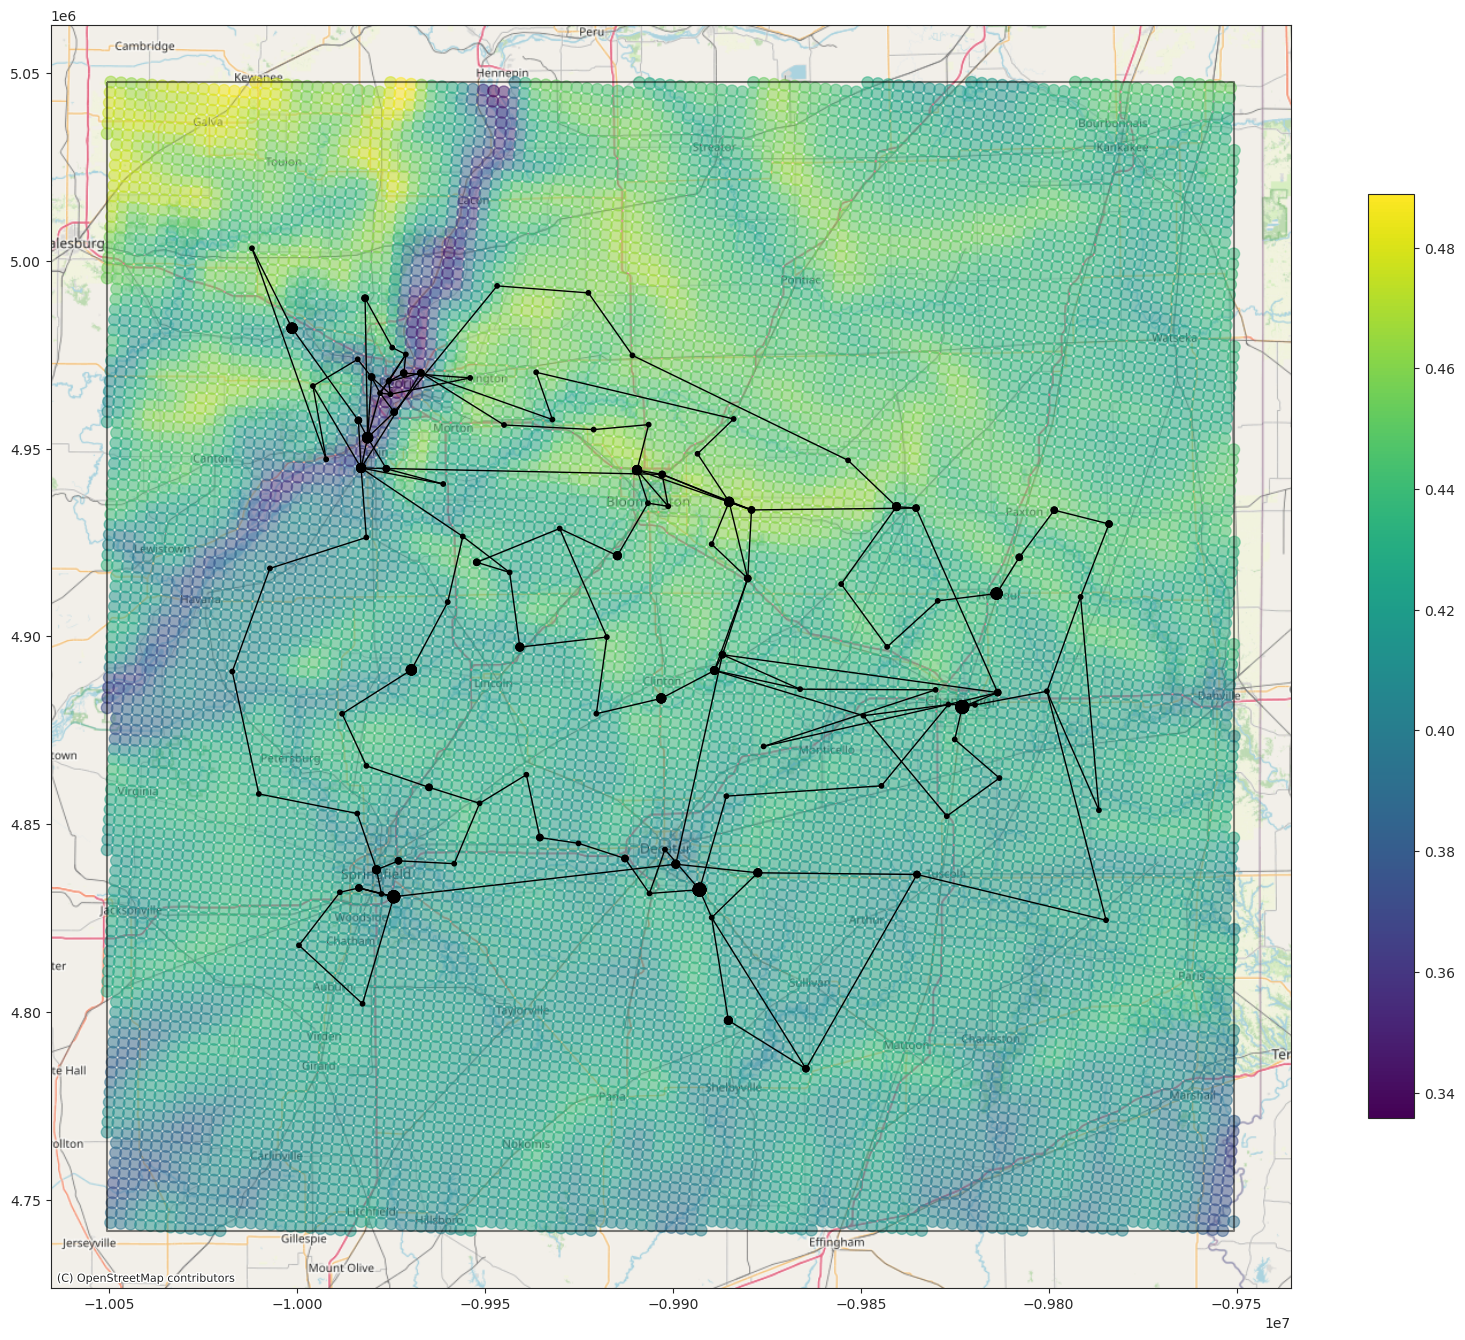

In [28]:
# # make gdf with project points
# cf_df["geometry"] = [Point(x, y) for x, y in zip(cf_df["longitude"], cf_df["latitude"])]
# # cf_df
# # “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
# cf_gdf = gpd.GeoDataFrame(cf_df, geometry="geometry", crs="epsg:4326")

cf_gdf = cf_gdf.to_crs("epsg:3857")
# plt.figure(figsize=(20, 20))
ax = cf_gdf.plot(
    figsize=(20, 20),
    markersize=70,
    column="cf_mean",
    legend=True,
    legend_kwds={
        "shrink": 0.6,
    },
    alpha=0.5,
    cmap="viridis",
)


# Web Mercator
# rts_box_gdf = rts_box_gdf.to_crs(epsg=3857)
bus_gdf = bus_gdf.to_crs(epsg=3857)
br_gdf = br_gdf.to_crs(epsg=3857)
# bus_gdf.plot(ax=ax, color="black",  markersize = 5)
bus_gdf.plot(ax=ax, color="black", markersize="size")

br_gdf.plot(ax=ax, color="black", linewidth=1)


####### based on project points, draw a box (OPTIONAL)
top = pps_df["latitude"].max()
bottom = pps_df["latitude"].min()
left = pps_df["longitude"].min()
right = pps_df["longitude"].max()

lat_point_list = [top, top, bottom, bottom]
lon_point_list = [left, right, right, left]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
tamu_box_gdf = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[polygon_geom])
# print(polygon.geometry)

tamu_box_gdf = tamu_box_gdf.to_crs("epsg:3857")
tamu_box_gdf.boundary.plot(ax=ax, alpha=0.5, edgecolor="k")


# ####### add map tile stamen tile service is retiring 
# ctx.add_basemap(ax)

# By default, contextily uses the Stamen Terrain style. We can specify a different style using "source" kwarg
# full list in ctx.sources module or 
# https://github.com/geopandas/contextily


ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
#ctx.add_basemap(ax,source=ctx.providers.OpenTopoMap)
#ctx.add_basemap(ax,source=ctx.providers.Stamen.Terrain)
#ctx.add_basemap(ax,source=ctx.providers.Stamen.Toner)



# ### save figure in work dir (since this is the same for all buildout options)
# ax.set_axis_off()
# filename = os.path.join(work_dir, "cfs_all.png")
# plt.savefig(filename, bbox_inches="tight", pad_inches=0)

## high df
* can skipp, will do this in Part2

In [29]:
# # select all sites in the box, selection by distance will be done later
# selected_df = cf_df.copy()

# # # capacity factor cutoff (old reV)
# # cf_cutoff = 400
# # capacity factor cutoff (new reV)
# cf_cutoff = 0.40

# high_df = selected_df.loc[selected_df["cf_mean"] >= cf_cutoff]
# low_df = selected_df.loc[selected_df["cf_mean"] < cf_cutoff]

# # color_map = ["blue" if x < cf_cutoff else "red" for x in selected_df["cf_mean"]]
# # len(color_map)


# # print('RTS total load (MWh):{:,}'.format(36581383.0))
# total_generation = high_df["generation_mwh"].sum()
# print(
#     "total generation of selected high capacity sites (MWh):{:,}".format(
#         round(total_generation)
#     )
# )

# # total_generation /36581383.0
# print("\nhigh_df:")
# high_df
# print("\nlow_df:")
# low_df

# ###############
# #### for gdp viz

# # make gdf with project points
# high_df["geometry"] = [Point(x, y) for x, y in zip(high_df["longitude"], high_df["latitude"])]
# # cf_df
# # “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
# high_gdf = gpd.GeoDataFrame(high_df, geometry="geometry", crs="epsg:4326")
# high_gdf = high_gdf.to_crs("epsg:3857")


### save/load checkpoint (optional)
* uncomment next two cells as needed

In [32]:
# ### save high_df and low_df
# run_dir
# filename = "high_cf_df.csv"
# high_df.to_csv(os.path.join(run_dir, filename))
# filename = "low_cf_df.csv"
# low_df.to_csv(os.path.join(run_dir, filename))

In [33]:
# ### load
# filename = "high_cf_df.csv"
# high_df = pd.read_csv(os.path.join(run_dir, filename), index_col=0)


# # make gdf with project points
# high_df["geometry"] = [
#     Point(x, y) for x, y in zip(high_df["longitude"], high_df["latitude"])
# ]
# # cf_df
# # “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
# high_gdf = gpd.GeoDataFrame(high_df, geometry="geometry", crs="epsg:4326")
# high_gdf = high_gdf.to_crs("epsg:3857")

# high_gdf

[Run reV](#run_rev)

* apply exclusions
<a id='apply_exclusions'></a>

[Go to the end](#the_end)

# inclusion/exclusion

 * select your exclusion mask
 * pip install rasterio to read .tif files
 * projection used: North America Albers Equal Area Conic
 https://spatialreference.org/ref/esri/102008/
 * pip install pyproj to transform (lat,lon) to .tif file coordinates
 * in tif files: 0 is fully excluded, 100 fully included

### run once, takes a while
* might cause memory error
* if causes MemoryError (Unable to allocate 6.12 GiB for an array with shape (33792, 48640) and data type float32), comment out: show(img), plt.figure(), and plt.imshow()
* 

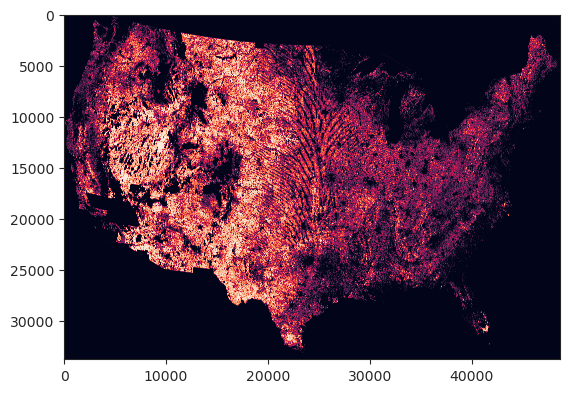

In [34]:
### mask file
fp = "/projects/hpcapps/isatkaus/grid-buildouts-data/exclusion-masks/05_b_b_mid_inclusion_mask_inclusion_mask.tif"

img = rasterio.open(fp)
# show(img)

dataset = rasterio.open(fp)

# # read into np n-d array
band1 = dataset.read(1)
# plt.figure(figsize=(5, 10))
plt.imshow(band1)

In [35]:
# p = pyproj.Proj(
#     "+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6378137 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
# )

# ESRI North America Albers equal area conic projection
p = pyproj.Proj(
    "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
)

## one cell
* take a look at one gid cell with exclusions applied 

(12943, 32201)

(12966, 32224)

<Figure size 1000x1000 with 0 Axes>

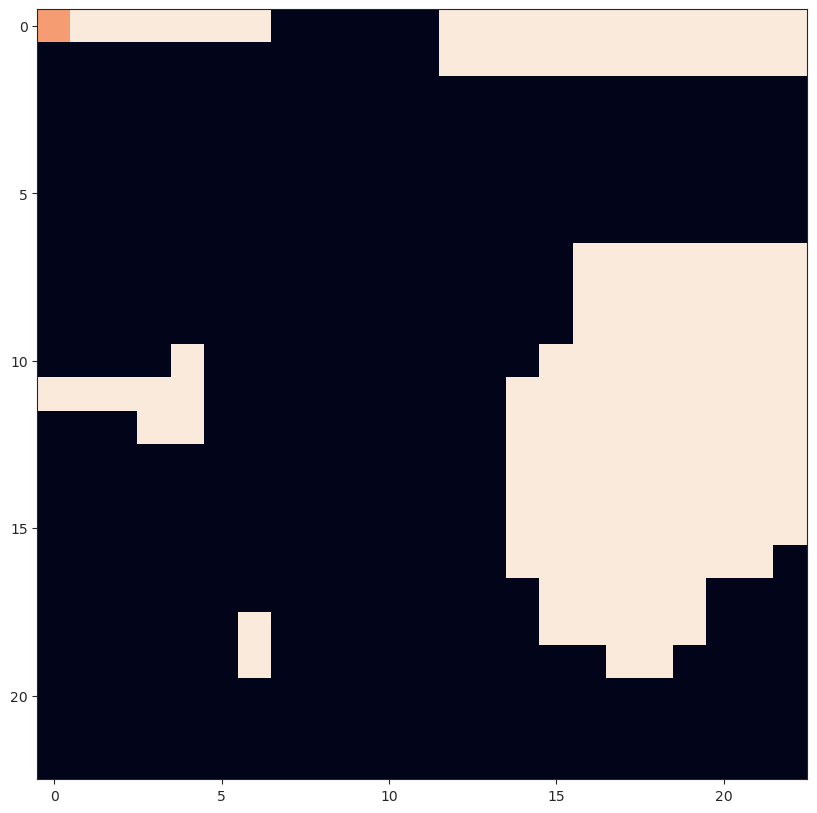

In [36]:
# lat on of one WTK gid=413850
#lat0, lon0 = 33.686546, -114.395737

#cf_idx = 379449
cf_idx = cf_df.index[2006]
cf_idx = cf_df.index[2007]
cf_idx = cf_df.index[2016]

lat0, lon0 = tuple(cf_df.loc[cf_idx, ["latitude", "longitude"]].values)

# to Albers
x0, y0 = p(lon0, lat0, inverse=False)
# x0, y0 are coordinates of the center of WTK cell

# x y  left top corner
x1 = x0 - 1000
y1 = y0 + 1000

# x y  right bottom corner
x2 = x0 + 1000
y2 = y0 - 1000


# to index
row1, col1 = dataset.index(x1, y1)
row2, col2 = dataset.index(x2, y2)

row1, col1
row2, col2

cell = band1[row1:row2, col1:col2]
plt.figure(figsize=(10, 10))
plt.imshow(cell)

# #### save fig
# save_dir = os.path.join(run_dir,"figures")
# filename = "one_cell_with_exclusions.png"
# plt.savefig(os.path.join(save_dir,filename),  bbox_inches='tight',   )


In [37]:
actual_inclusion = cell.sum()
actual_inclusion
possible_inclusion = cell.shape[0] * cell.shape[1] * 100
possible_inclusion
print("inclusion fraction: {}".format(round(actual_inclusion / possible_inclusion, 2)))

13280

52900

inclusion fraction: 0.25


# all cells: inclusion/exclusion
* go cell by cell, record inclusion
* will take a while
* will use inclusion column in part2
* then save all_cf_df.csv, and proceed to part2

### apply exclusions to all cf

In [38]:
cf_gdf

cf_mean   latitude  longitude  generation_mwh  \
gid                                                       
1616332  0.380393  40.916645 -89.543488    36654.648438   
1616333  0.386721  40.935162 -89.541504    37264.468750   
1616334  0.395369  40.953659 -89.539520    38097.738281   
1616335  0.409028  40.972168 -89.537537    39413.910156   
...           ...        ...        ...             ...   
1690944  0.434196  40.722565 -88.064178    41839.121094   
1690945  0.434934  40.741035 -88.061737    41910.269531   
1690946  0.434824  40.759506 -88.059326    41899.621094   
1690947  0.433640  40.777973 -88.056885    41785.542969   

                                 geometry  
gid                                        
1616332  POINT (-9967935.438 5000054.591)  
1616333  POINT (-9967714.620 5002782.712)  
1616334  POINT (-9967493.802 5005508.786)  
1616335  POINT (-9967272.984 5008237.312)  
...                                   ...  
1690944  POINT (-9803259.504 4971505.744)  
1690945  POINT (-9802987.728 4974219.166)  
1690946  POINT (-9802719.349 4976933.342)  
1690947  POINT (-9802447.573 4979647.711)  

[12563 rows x 5 columns]

In [39]:
for cf_idx in cf_gdf.index[:]:
    lat0, lon0 = tuple(cf_gdf.loc[cf_idx, ["latitude", "longitude"]].values)

    # to Albers
    x0, y0 = p(lon0, lat0, inverse=False)
    # x0, y0 are coordinates of the center of WTK cell

    # x y  left top corner
    x1 = x0 - 1000
    y1 = y0 + 1000

    # x y  right bottom corner
    x2 = x0 + 1000
    y2 = y0 - 1000

    # to index
    row1, col1 = dataset.index(x1, y1)
    row2, col2 = dataset.index(x2, y2)

    #     row1, col1
    #     row2, col2

    cell = band1[row1:row2, col1:col2]

    total_points = cell.shape[0] * cell.shape[1] * 100
    incl_percent = cell.sum() / (cell.shape[0] * cell.shape[1] * 100)
    # incl_percent
    cf_gdf.loc[cf_idx, "inclusion"] = incl_percent

cf_gdf

cf_mean   latitude  longitude  generation_mwh  \
gid                                                       
1616332  0.380393  40.916645 -89.543488    36654.648438   
1616333  0.386721  40.935162 -89.541504    37264.468750   
1616334  0.395369  40.953659 -89.539520    38097.738281   
1616335  0.409028  40.972168 -89.537537    39413.910156   
...           ...        ...        ...             ...   
1690944  0.434196  40.722565 -88.064178    41839.121094   
1690945  0.434934  40.741035 -88.061737    41910.269531   
1690946  0.434824  40.759506 -88.059326    41899.621094   
1690947  0.433640  40.777973 -88.056885    41785.542969   

                                 geometry  inclusion  
gid                                                   
1616332  POINT (-9967935.438 5000054.591)   0.160681  
1616333  POINT (-9967714.620 5002782.712)   0.111570  
1616334  POINT (-9967493.802 5005508.786)   0.274793  
1616335  POINT (-9967272.984 5008237.312)   0.422925  
...                                   ...        ...  
1690944  POINT (-9803259.504 4971505.744)   0.359168  
1690945  POINT (-9802987.728 4974219.166)   0.411157  
1690946  POINT (-9802719.349 4976933.342)   0.361570  
1690947  POINT (-9802447.573 4979647.711)   0.450593  

[12563 rows x 6 columns]

In [40]:
### save all_cf_df with inclusion percentages
run_dir
filename = "all_cf_df.csv"
cf_gdf.to_csv(os.path.join(run_dir, filename))

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

# Proceed to Part2
* can proceed to tamu200_buildout_part2.ipynb
* note run_dir - we'll need it in Part2


[Apply exclusions](#apply_exclusions)

* the end
<a id='the_end'></a>

In [44]:
run_dir

'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'

In [45]:
print("blet")

blet
